In [1]:
import pandas as pd
from unidecode import unidecode
from model2vec import StaticModel
import matplotlib.pyplot as plt
import numpy as np
import spacy 
from nltk.corpus import stopwords
import string 
import re 
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df_data = pd.read_csv('../data/sale_data/1_sale_clean.csv')
df_data['house_id']='house_'+df_data.index.astype(str)
df_data.head(2)

,citta,bagni,stanze,piano,regione,m2,quartiere,description,via,disponibilità,prezzo,delta_pubblicazione,totale_piani,ascensore,cucina,camere,tipologia_casa,classe_casa,tipologia_proprietà,n posti auto,box privato,balcone,impianto tv singolo,porta blindata,parzialmente arredato,cantina,esposizione doppia,arredato,caminetto,terrazza,impianto di allarme,portiere,piscina_idromassaggio,videocitofono,cancello elettrico,fibra ottica,armadio a muro,impianto tv centralizzato,mansarda,giardino,infissi,house_id
0,Rosignano Marittimo,1,quadrilocale,1,toscana,100,Piazza Pietro Gori,ROSIGNANO MARITTIMO – OTTIMO APPARTAMENTO IN C...,missing,Libero,123000.00,0,2,0,cucina abitabile,2,Appartamento,Classe immobile media,Intera proprietà,0,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,missing,doppio,house_0
1,Milano,1,pentalocale,3,lombardia,100,Certosa,"ACCURSIO/CERTOSA, VIA MICHELINO DA BESOZZO, MI...",Via Michelino da Besozzo,Libero,345000.00,1,8,1,cucina abitabile,3,Appartamento,Classe immobile media,Intera proprietà,0,False,True,False,True,False,True,True,False,False,False,False,True,False,False,False,True,False,True,False,missing,singolo,house_1


### Aggiunta Popolazione e Reddito

In [3]:
abitanti = pd.read_csv('../data/feature_data/abitanti.csv')
abitanti['DESCRIZIONE COMUNE'] = abitanti['DESCRIZIONE COMUNE'].str.replace("'","").str.lower()
abitanti.rename({'DESCRIZIONE COMUNE':'citta', 'POPOLAZIONE CENSITA TOTALE':'popolazione'}, axis=1, inplace=True)
abitanti['popolazione']=abitanti['popolazione'].str.replace('.','').astype(int)
abitanti.head(2)

,citta,POPOLAZIONE CENSITA UOMINI,POPOLAZIONE CENSITA DONNE,popolazione
0,abano terme,9.556,10.567,20123
1,abbadia cerreto,139,136,275


In [4]:
fix_citta_dict = {'Reggio Emilia': 'REGGIO NELLEMILIA', 'Montemagno':'MONTEMAGNO MONFERRATO', 
             'Calatafimi-Segesta':'CALATAFIMI SEGESTA','Giardini-Naxos':'GIARDINI NAXOS', 'Trentola-Ducenta':'TRENTOLA DUCENTA', 
             'Bolzano':'BOLZANO/BOZEN', 'Appiano sulla Strada del Vino':'APPIANO SULLA STRADA DEL VINO/EPPAN AN DER WEINSTRASSE', 
             'Laives':'LAIVES/LEIFERS', 'Merano':'MERANO/MERAN', 'Montescudo - Montecolombo':'MONTESCUDO - MONTE COLOMBO', 
             'Crespina e Lorenzana':'CRESPINA LORENZANA'}

def fix_citta(city):
    if city in fix_citta_dict.keys():
        return fix_citta_dict[city]
    return city

In [5]:
df_data['citta'] = df_data['citta'].map(unidecode).str.replace("'","").map(fix_citta).str.lower()
df_data = pd.merge(df_data, abitanti[['citta', 'popolazione']], how='left', on='citta')
df_data.loc[df_data['popolazione'].isna(), 'popolazione']=-1

In [6]:
reddito = pd.read_csv('../data/feature_data/reddito_by_regione.csv')
reddito = reddito[reddito['T_D8']=='REDD_MEDIANO_FAM'][['Territorio', 'Value']].rename({'Territorio':'regione', 'Value':'reddito mediano'}, axis=1)
df_data['regione']=df_data['regione'].str.lower()
reddito['regione'] = reddito['regione'].str.lower()
reddito.loc[reddito['regione']=="valle d'aosta / vallée d'aoste", 'regione'] = 'valle-d-aosta'
reddito.loc[reddito['regione']=="provincia autonoma bolzano / bozen", 'regione'] = 'trentino-alto-adige'
reddito.loc[reddito['regione']=="friuli-venezia giulia", 'regione'] = 'friuli-venezia-giulia'
df_data = pd.merge(df_data, reddito, how='left', on='regione')

### Valutazione description

In [7]:
df_data['da ristrutturare'] = False
df_data.loc[df_data['description'].str.lower().str.contains('ristrutturare'), 'da ristrutturare'] = True
df_data['da ristrutturare'].value_counts()

da ristrutturare
False    15396
True       847
Name: count, dtype: int64

In [8]:
df_data['ristrutturato'] = False
df_data.loc[df_data['description'].str.lower().str.contains('ristrutturat'), 'ristrutturato'] = True
df_data['ristrutturato'].value_counts()

ristrutturato
False    12647
True      3596
Name: count, dtype: int64

In [9]:
df_data['ben collegato'] = False
df_data.loc[df_data['description'].str.lower().str.contains('collegat'), 'ben collegato'] = True
df_data['ben collegato'].value_counts()

ben collegato
False    14746
True      1497
Name: count, dtype: int64

In [10]:
df_data['lavanderia'] = False
df_data.loc[df_data['description'].str.lower().str.contains('lavanderia'), 'lavanderia'] = True
df_data['lavanderia'].value_counts()

lavanderia
False    12985
True      3258
Name: count, dtype: int64

In [11]:
df_data['ripostiglio'] = False
df_data.loc[df_data['description'].str.lower().str.contains('ripostiglio'), 'ripostiglio'] = True
df_data['ripostiglio'].value_counts()

ripostiglio
False    11564
True      4679
Name: count, dtype: int64

In [12]:
df_data['bagno finestrato'] = False
df_data.loc[(df_data['description'].str.lower().str.contains('bagno finestrato')) | (df_data['description'].str.lower().str.contains('bagni finestrati')), 'bagno finestrato'] = True
df_data['bagno finestrato'].value_counts()

bagno finestrato
False    14215
True      2028
Name: count, dtype: int64

In [13]:
df_data['luminoso'] = False
df_data.loc[df_data['description'].str.lower().str.contains('luminoso'), 'luminoso'] = True
df_data['luminoso'].value_counts()

luminoso
False    12932
True      3311
Name: count, dtype: int64

In [14]:
df_data['parquet'] = False
df_data.loc[df_data['description'].str.lower().str.contains('parquet'), 'parquet'] = True
df_data['parquet'].value_counts()

parquet
False    14787
True      1456
Name: count, dtype: int64

In [15]:
df_data['aria condizionata'] = False
df_data.loc[df_data['description'].str.lower().str.contains('aria condizionata'), 'aria condizionata'] = True
df_data['aria condizionata'].value_counts()

aria condizionata
False    14401
True      1842
Name: count, dtype: int64

In [16]:
df_data['parchi e verde'] = False
df_data.loc[(df_data['description'].str.lower().str.contains('parchi')) | (df_data['description'].str.lower().str.contains('verde')), 'parchi e verde'] = True
df_data['parchi e verde'].value_counts()

parchi e verde
False    13519
True      2724
Name: count, dtype: int64

In [17]:
df_data['ultimo'] = False
df_data.loc[df_data['description'].str.lower().str.contains('ultimo'), 'ultimo'] = True
df_data['ultimo'].value_counts()

ultimo
False    14272
True      1971
Name: count, dtype: int64

In [18]:
nlp = spacy.load('it_core_news_sm',  disable=['ner', 'textcat'])

In [19]:
clean_stopwords = set(stopwords.words('italian'))
clean_punctuation = ''.join(set(string.punctuation))
def lemmatize(text):
    return ' '.join(token.lemma_ for token in nlp(text))

def remove_punct(text):
    return text.translate(str.maketrans('', '', clean_punctuation)) 

def remove_stopwords(text):
    return ' '.join(i.lower().strip() for i in lemmatize(text).split() if i not in clean_stopwords and len(i)>=2)

def remove_email(text):
    return re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", text)

def remove_numbers(text):
    return re.sub(r'[0-9]+',"", text)

def clean_text(text):
    text = remove_email(text)
    text = lemmatize(text)
    text = remove_punct(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    return text

In [20]:
df_data.reset_index(drop=True, inplace=True)
df_data['description'] = df_data['description'].map(clean_text)

In [21]:
model = StaticModel.from_pretrained("minishlab/m2v_multilingual_output")

c:\Users\faceru\OneDrive - SAS\Documents\Personal\Italy_House_Prices\house_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
embeddings = model.encode(df_data['description'])
embeddings = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])
df_data_full = pd.concat([df_data, embeddings], axis=1)
df_data_full.drop('description', inplace=True, axis=1)

### Log Transform

In [23]:
df_data_full[['prezzo', 'm2']].describe(percentiles=[i/10 for i in range(1,10)])

,prezzo,m2
count,16243.00,16243.00
mean,581011.73,185.09
std,10696636.95,1554.08
min,1.00,1.00
10%,114000.00,65.00
20%,155000.00,80.00
30%,195000.00,90.00
40%,238000.00,102.00
50%,280000.00,116.00
60%,338000.00,132.00


In [24]:
min_price = 40000
min_m2 = 40
max_price = 2000000
max_m2 = 500
n_obs_orig = df_data_full.shape[0]
df_data_full_clean = df_data_full[(df_data_full['prezzo'].between(min_price, max_price, inclusive='both'))&(df_data_full['m2'].between(min_m2, max_m2, inclusive='both'))].reset_index(drop=True)
n_obs_new = df_data_full_clean.shape[0]
print(f'Keeping {min_price}<=Price<={max_price} and {min_m2}<=M2<={max_m2}', f'---> {n_obs_orig-n_obs_new} observations dropped')
df_data_full_clean[['prezzo', 'm2']].describe(percentiles=[i/10 for i in range(1,10)])

Keeping 40000<=Price<=2000000 and 40<=M2<=500 ---> 919 observations dropped


,prezzo,m2
count,15324.00,15324.00
mean,368461.15,136.26
std,306743.22,77.46
min,40000.00,40.00
10%,115000.00,65.00
20%,155000.00,80.00
30%,190000.00,90.00
40%,235000.00,100.00
50%,275000.00,115.00
60%,329000.00,130.00


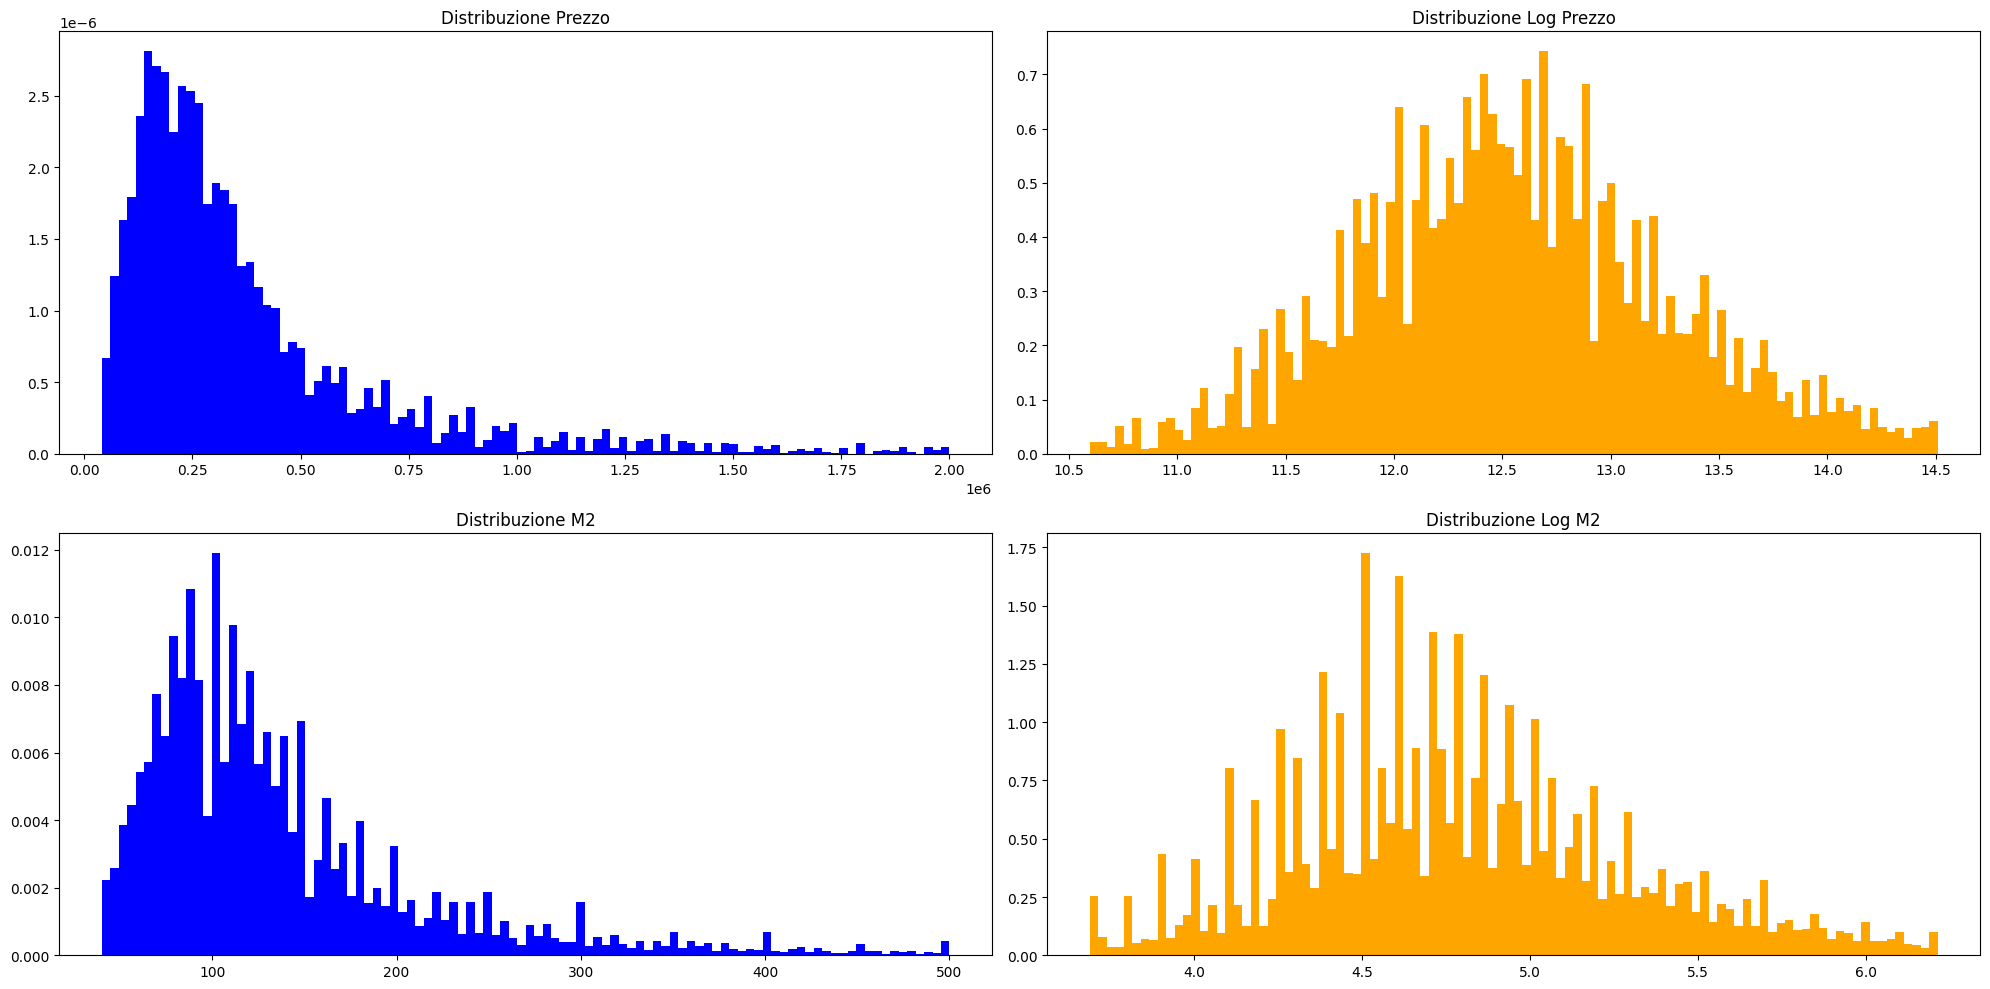

In [25]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,10))
ax=axs.ravel()
ax[0].hist(df_data_full_clean['prezzo'], bins=100, color='blue', density=True)
ax[0].set_title('Distribuzione Prezzo')
ax[1].hist(np.log(df_data_full_clean['prezzo']), bins=100, color='orange', density=True)
ax[1].set_title('Distribuzione Log Prezzo')
ax[2].hist(df_data_full_clean['m2'], bins=100, color='blue', density=True)
ax[2].set_title('Distribuzione M2')
ax[3].hist(np.log(df_data_full_clean['m2']), bins=100, color='orange', density=True)
ax[3].set_title('Distribuzione Log M2')
plt.tight_layout()
plt.show()

In [26]:
df_data_full_clean['log_prezzo']=np.log(df_data_full_clean['prezzo'])
df_data_full_clean['log_m2']=np.log(df_data_full_clean['m2'])

### Save

In [27]:
df_data_full_clean.to_csv('../data/sale_data/2_sale_enriched.csv', index=False)